In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation as R
import tqdm

# Load Data

In [2]:
lidar_df = pd.read_csv("../data/raw_dataset_lidar.csv")
odom_df = pd.read_csv("../data/raw_dataset_odom.csv")

## Process Raw Data

In [3]:
## From anupama_dev
# selecting useful features
lidar_cols = ['frame_id', 'time_sec', 'time_nanosec', 'ranges']
odom_cols = ['frame_id', 'position_x', 'position_y', 'position_z', 'velocity_x', 'velocity_y', 'velocity_z', 'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w', 'omega_x', 'omega_y', 'omega_z']

# DataFrames containing (almost) matched lidar and odom data
lidar_match = pd.DataFrame()
odom_match = pd.DataFrame()

times_s = lidar_df['time_sec']
times_nano = lidar_df['time_nanosec']
for i in range(len(times_s)):
  # selecting frames with same time (s)
  odoms_s = odom_df[odom_df['time_sec'] == times_s[i]]
  # matching data with least time (nanosec) diff
  diff_nanosec = pd.Series(odoms_s['time_nanosec'] - lidar_df.iloc[i]['time_nanosec'])
  min_diff = abs(diff_nanosec).idxmin()
  lidar_match = pd.concat([lidar_match, lidar_df.loc[i, lidar_cols]], axis=1)
  odom_match = pd.concat([odom_match, odoms_s.loc[min_diff, odom_cols]], axis=1)

# ensuring cols are the featuers
lidar_match = lidar_match.T
odom_match = odom_match.T

# substituting 'frame_id' fields with ranges to help merge later
lidar_match['frame_id'] = range(len(lidar_match))
odom_match['frame_id'] = range(len(odom_match))

# merged DataFrame with both lidar and odom data
merged_df = lidar_match.merge(odom_match, how="inner", on='frame_id')
# merged_df

In [4]:
# from pierros-dev
def expand_column(df, column_name):
    # Remove brackets and extra spaces/newlines, then split into individual values
    clean_data = df[column_name].apply(lambda x: x.replace('[', '').replace(']', '').replace('\n', ' ').strip().split())
    # Convert 'inf' to np.inf and convert values to float
    clean_data = clean_data.apply(lambda x: [np.inf if v == 'inf' else float(v) for v in x])
    
    # Create a new DataFrame with the expanded columns
    expanded_df = pd.DataFrame(clean_data.tolist(), index=df.index)
    # Rename the columns
    expanded_df.columns = [f"{column_name}_{i+1}" for i in range(expanded_df.shape[1])]
    
    return expanded_df

In [5]:
merged_df = pd.read_csv("../data/merged_lidar_odom_data.csv")
# merged_df = lidar_match.merge(odom_match, how="inner", on='frame_id')
merged_df = pd.concat([merged_df, expand_column(merged_df, 'ranges')], axis=1)
merged_df = merged_df.drop(["ranges"], axis=1)
# merged_df

## Extract Obstacles

In [6]:
# from anupama-dev
def radar_data(df):
    # Replace np.inf with np.nan
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Select columns starting with 'ColumnX'
    columns_to_plot = df.filter(regex='^ranges_').columns

    # Convert selected columns to numeric
    df[columns_to_plot] = df[columns_to_plot].apply(pd.to_numeric, errors='coerce')

    data = []

    for row_index in range(len(df)):
        # Extract data for the specified row and columns
        data_to_plot = df.loc[row_index, columns_to_plot]

        # Check if data_to_plot is empty or all NaNs
        if data_to_plot.isnull().all():
            print(f"No valid data found for Row {row_index}. Radar plot cannot be generated.")
        else:
            data_to_plot = np.concatenate((data_to_plot.values, [data_to_plot.values[0]]))
            data.append(data_to_plot)

    # Number of variables
    num_vars = len(columns_to_plot)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop" and append the start value to the end.
    angles += angles[:1]

    return num_vars, angles, data

In [7]:
def radar_animation(df):
    num_vars, angles, data = radar_data(df)

    # Plotting radar plot
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
    # ax.fill(angles, data_to_plot, color='blue', alpha=0.25)
    ax.set_theta_offset(np.pi / 2)
    ax.set_yticklabels([])  # Hide radial ticks

    def update_frame(frame):
        ax.clear()
        ax.set_theta_offset(np.pi / 2)
        ax.set_yticklabels([])
        ax.set_title(f'Radar Plot of ColumnX for Row {frame}', fontsize=12, fontweight='bold', pad=20)  # Title of the plot
        
        values = data[frame]

        # Plot data
        ax.fill(angles, values, color='blue', alpha=0.25)
        ax.plot(angles, values, color='blue', linewidth=2)

    anim = FuncAnimation(fig, update_frame, frames=num_vars, interval=100)
    anim.save('radar_plot.gif', writer = 'ffmpeg', fps = 30)

# radar_animation(merged_df) # saved animation in radar_plot.gif

## Switching to cartesian coordinates

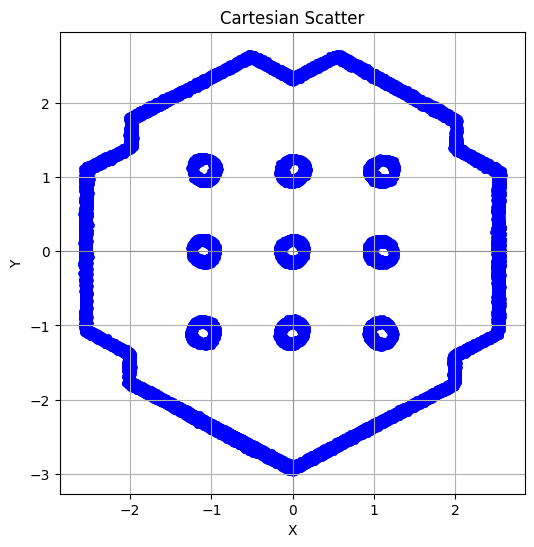

In [9]:
num_vars, angles, data = radar_data(merged_df)

pos_x = merged_df['position_x']
pos_y = merged_df['position_y']
pos_z = merged_df['position_z']

orient_x = merged_df['orientation_x']
orient_y = merged_df['orientation_y']
orient_z = merged_df['orientation_z']
orient_w = merged_df['orientation_w']

def sensor_to_world_frame(index):
    r = np.array(data[index])
    theta = np.array(angles) + np.pi/2

    # converting polar coordinates to cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # retrieving rotation matrix from quaternion measurement values
    rot = R.from_quat([orient_x[index], orient_y[index], orient_z[index], orient_w[index]])

    # converting sensor frame measurements to world frame measurements

    # rotation
    pts_vector = np.array([x[:-1], y[:-1], np.ones((num_vars))])  # remember data has +1 element due to completing radar circle
    pts_rotated = rot.as_matrix() @ pts_vector
    x, y, _ = pts_rotated

    # translation
    x -= pos_y.iloc[index]
    y += pos_x.iloc[index]

    return x, y

pts_x = np.array([]) # still includes nan values
pts_y = np.array([]) # still includes nan values
# converting all data to world frame
for i in range(len(data)):
    x, y = sensor_to_world_frame(i)
    pts_x = np.append(pts_x, x)
    pts_y = np.append(pts_y, y)

# plotting final map
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(pts_x, pts_y, color='blue', s=15)

plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Cartesian Scatter')
plt.show()

# DBSCAN

In [10]:
# Data Transformation
points = np.column_stack((pts_x, pts_y))

finite_mask = np.isfinite(points)
max_finite_value = np.max(points[finite_mask])
min_finite_value = np.min(points[finite_mask])
points[np.isposinf(points)] = max_finite_value
points[np.isneginf(points)] = min_finite_value

points = points[~np.isnan(points).any(axis=1)]
points.shape

(270089, 2)

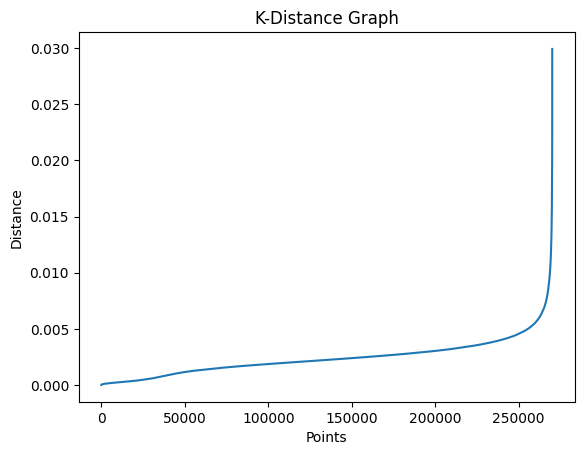

In [18]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from DBSCAN import DBSCAN

# Step 1: K-Distance Graph
def plot_k_distance_graph(points, k):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(points)
    distances, indices = neighbors_fit.kneighbors(points)
    distances = np.sort(distances[:, k-1], axis=0)
    plt.plot(distances)
    plt.ylabel('Distance')
    plt.xlabel('Points')
    plt.title('K-Distance Graph')
    plt.show()

# Plot the k-distance graph to determine ε
plot_k_distance_graph(points, k=4)


In [20]:
# Step 2: Experiment with DBSCAN
def find_optimal_dbscan(points, eps_values, min_samples_values):
    '''
    This function finds the optimal parameters for DBSCAN based on the current experient data
    '''
    best_score = -1
    best_params = None
    for eps in tqdm.tqdm(eps_values):
        for min_samples in min_samples_values:
            # dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            # labels = dbscan.fit_predict(points)
            dbscan = DBSCAN(eps, min_samples, points)
            cluster_idx = dbscan.fit()
            if len(set(cluster_idx)) > 1:
                score = silhouette_score(points, cluster_idx)
                if score > best_score:
                    best_score = score
                    best_params = (eps, min_samples)
    return best_params, best_score

# Define ranges for eps and min_samples
eps_values = np.linspace(0.1, 1.0, 10)
min_samples_values = range(3, 10)

# Find the optimal parameters
best_params, best_score = find_optimal_dbscan(points, eps_values, min_samples_values)

print(f"Optimal ε: {best_params[0]}")
print(f"Optimal min_samples: {best_params[1]}")
print(f"Best silhouette score: {best_score}")

# Fit DBSCAN with the optimal parameters
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
labels = dbscan.fit_predict(points)

# Plot the resulting clusters
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='plasma')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering')
plt.savefig("optimal_DBSCAN_clustering.png") 
plt.show()


  0%|          | 0/10 [00:21<?, ?it/s]


KeyboardInterrupt: 

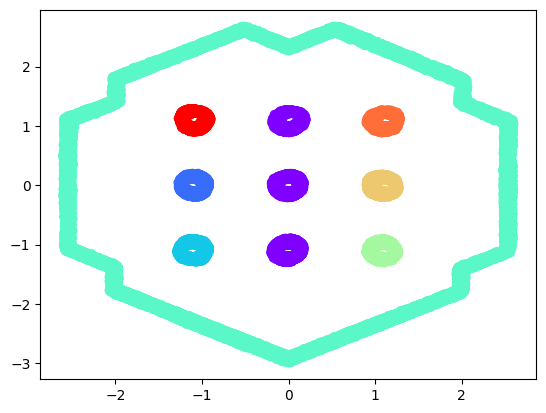

In [11]:
def visualise(X, C, K=None):  
    '''
    Visualization of clustering.
    '''
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], c=C, cmap="rainbow")
    if K:
        plt.title("Visualization of K = " + str(K), fontsize=15)
    plt.show()
    pass

BEST_EPS = 0.7
BEST_POINTS = 3

dbscan = DBSCAN(BEST_EPS, BEST_POINTS, points)
cluster_idx = dbscan.fit()
visualise(points, cluster_idx)

In [14]:
from sklearn.metrics import silhouette_score
score = silhouette_score(points, cluster_idx)

In [17]:
score

np.float64(-0.285192470795157)